In [3]:
from IPython.utils.path import glob
# @title Mount to Drive, then pip install SimpleElastix
# I used a google colab notebook, and this is the only way I know how to access
# external files
from google.colab import drive
drive.mount('/content/drive/')

import subprocess, sys
def pip_install(package):
    print(f"Trying to install {package} ...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", package],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
    )
    print(result.stdout)
    return result.returncode == 0

pip_install("SimpleITK-SimpleElastix")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Trying to install SimpleITK-SimpleElastix ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 8.3 MB/s eta 0:00:00



True

In [4]:
# every other import used in this code
import os, glob
import numpy as np
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [5]:
#@title user-defined functions for quantitative analysis
def sitk_to_normalized_numpy(img):
    """Convert SimpleITK image to float32 NumPy in [0,1]."""
    arr = sitk.GetArrayFromImage(img).astype(np.float32)

    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]

    mn, mx = arr.min(), arr.max()
    if mx > mn:
        arr = (arr - mn) / (mx - mn)
    else:
        arr = np.zeros_like(arr)
    return arr

def compute_mse(img1, img2):
    diff = img1 - img2
    return float(np.mean(diff**2))

def compute_psnr(img1, img2, data_range=1.0):
    mse = compute_mse(img1, img2)
    if mse == 0:
        return float("inf")
    return float(10 * np.log10((data_range**2) / mse))

def compute_ncc(img1, img2):
    x = img1.flatten()
    y = img2.flatten()
    x_mean = x.mean()
    y_mean = y.mean()
    x_cent = x - x_mean
    y_cent = y - y_mean
    num = np.sum(x_cent * y_cent)
    den = np.sqrt(np.sum(x_cent**2) * np.sum(y_cent**2)) + 1e-12
    return float(num / den)

def compute_ssim(img1, img2):
    return float(ssim(img1, img2, data_range=1.0))


In [6]:
#@title global variables - transformation parameters
# will probably be set to rand() within a reasonable range
theta = np.deg2rad(10)           # degrees
translation_x = 5.0     # normalized to image scale
translation_y = -10.0
shear_factor_x = 0.2
shear_factor_y = 0.1
poisson_scale_factor = 20.0 # Tune this value, set to zero to
                            # temporarily disable noise

In [7]:
#@title main function for applying distortions and computing registration
fixed_dir  = "/content/drive/MyDrive/Fall 2025/6127 - MSP/MSP Final Project/fixed_xrays"
moving_dir = "None"
def register_pair_and_metrics(fixed_path, moving_path=None, case_id=None):
    """
    fixed_path: path to fixed (reference) X-ray folder in Drive
    moving_path: refers to a path of distorted X-ray folder in Drive,
                 but this should remain =None since we're using synthetic
                 distortions here.
    case_id: filename
    returns the registered image and a dictionary of metrics
    """
    # 1) Read fixed image
    fixed = sitk.ReadImage(fixed_path, sitk.sitkFloat32)

    # Ensure single-channel
    if fixed.GetNumberOfComponentsPerPixel() > 1:
        fixed = sitk.VectorIndexSelectionCast(fixed, 0)
        fixed = sitk.Cast(fixed, sitk.sitkFloat32)

    # padded canvas to remove unwanted artifacts due to cropping
    pad_frac = 0.20
    orig_size = fixed.GetSize()
    pad_x = int(orig_size[0] * pad_frac)
    pad_y = int(orig_size[1] * pad_frac)

    fixed_padded = sitk.ConstantPad(
        fixed,
        (pad_x, pad_y),
        (pad_x, pad_y),
        constant=0.0,
    )

    size_p     = fixed_padded.GetSize()
    spacing_p  = fixed_padded.GetSpacing()
    origin_p   = fixed_padded.GetOrigin()
    center_phys = [
        origin_p[0] + spacing_p[0] * size_p[0] / 2.0,
        origin_p[1] + spacing_p[1] * size_p[1] / 2.0,
    ]

    # 2) build moving image

    # this case, specifically, was never used:
    if moving_path is not None:
        # Real moving image from disk (no synthetic distortion)
        moving = sitk.ReadImage(moving_path, sitk.sitkFloat32)
        if moving.GetNumberOfComponentsPerPixel() > 1:
            moving = sitk.VectorIndexSelectionCast(moving, 0)
            moving = sitk.Cast(moving, sitk.sitkFloat32)

        # Pad moving the same way (you may want a smarter scheme in general)
        moving_padded = sitk.ConstantPad(
            moving,
            (pad_x, pad_y),
            (pad_x, pad_y),
            constant=0.0,
        )

    # this case is used to obtain all distortions and registration data
    else:
        # define Euler2DTransform & rotation, translation parameters
        euler = sitk.Euler2DTransform()
        euler.SetCenter(center_phys)
        euler.SetAngle(theta)
        euler.SetTranslation((translation_x, translation_y))

        # define AffineTransform & shear parameters
        affine = sitk.AffineTransform(2)
        m = list(affine.GetMatrix())
        m[1] = shear_factor_x
        m[2] = shear_factor_y
        affine.SetMatrix(m)
        affine.SetCenter(center_phys)

        # composite transform combines euler2D and affine transforms
        composite = sitk.CompositeTransform(2)
        composite.AddTransform(euler)
        composite.AddTransform(affine)

        moving_padded = sitk.Resample(
            fixed_padded,
            composite,
            sitk.sitkLinear,
            0.0,
            fixed_padded.GetPixelID(),
        )

    # 3) add Poisson noise to model X-ray quantum noise
    """
    note: previously attempted implmenting Gaussian noise, but was unable
    to observe significant effects. Also, Poisson noise is known to be more
    realistic anyways
    """
    # adjust poisson_scale_factor to control the amount of noise:
    # higher factor simulates more photons => less relative noise.
    if poisson_scale_factor > 0:
        # apply to fixed_padded
        fixed_array_float = sitk.GetArrayFromImage(fixed_padded)
        scaled_fixed_for_poisson = fixed_array_float * poisson_scale_factor
        noisy_scaled_fixed_array = np.random.poisson(scaled_fixed_for_poisson).astype(np.float32)
        noisy_fixed_array = noisy_scaled_fixed_array / poisson_scale_factor
        fixed_noisy = sitk.GetImageFromArray(noisy_fixed_array)
        fixed_noisy.CopyInformation(fixed_padded)
        # noisy reference image:
        fixed_noisy = sitk.Cast(fixed_noisy, sitk.sitkFloat32)

        # apply to moving_padded
        moving_array_float = sitk.GetArrayFromImage(moving_padded)
        scaled_moving_for_poisson = moving_array_float * poisson_scale_factor
        noisy_scaled_moving_array = np.random.poisson(scaled_moving_for_poisson).astype(np.float32)
        noisy_moving_array = noisy_scaled_moving_array / poisson_scale_factor
        moving_noisy = sitk.GetImageFromArray(noisy_moving_array)
        moving_noisy.CopyInformation(moving_padded)
        # noisy moving image:
        moving_noisy = sitk.Cast(moving_noisy, sitk.sitkFloat32)
    # case for temporarily disabling noise in troubleshooting
    else:
        fixed_noisy = fixed_padded
        moving_noisy = moving_padded

    # optional choice to smooth both images before registration
    # fixed_reg   = sitk.DiscreteGaussian(fixed_padded, 1.2)
    # moving_reg  = sitk.DiscreteGaussian(moving_padded, 1.2)
    """
    tried using the Gaussian smoothing once and found results to be "too ideal"
    """

    # 4) rigid -> affine registration with Elastix
    elastix = sitk.ElastixImageFilter()
    elastix.SetFixedImage(fixed_noisy)    # registration uses noisy reference
    elastix.SetMovingImage(moving_noisy)  # and moving images

    # rigid & affine registration parameters
    """
    rigid registration for correcting rotation and translation but preserves
    shape and size of image. Affine registration for correcting shear

    "AdvancedMattesMutualInformation" documentation:
    https://elastix.dev/doxygen/classelastix_1_1AdvancedMattesMutualInformationMetric.html
    optimized to reach better performance compared to the normalized version

    "NumberOfSpatialSamples": Specifies number of sample points used from
                              images to calculate the similarity metric.
    "MaximumNumberOfIterations": maximum number of optimization steps the
                                 algorithm will take to find the best transformation
    "NumberOfResolutions": Indicates that the registration will be performed
                           in a multi-resolution fashion
    These three params were determined by analyzing the performance vs. run
    time in a separate spreadsheet
    """

    pmap_rigid = sitk.GetDefaultParameterMap("rigid")
    pmap_rigid["Metric"] = ["AdvancedMattesMutualInformation"]
    pmap_rigid["NumberOfSpatialSamples"] = ["4000"]
    pmap_rigid["MaximumNumberOfIterations"] = ["200"]
    pmap_rigid["NumberOfResolutions"] = ["4"]
    pmap_rigid["AutomaticScalesEstimation"] = ["true"]
    pmap_rigid["AutomaticTransformInitialization"] = ["true"]
    pmap_rigid["AutomaticTransformInitializationMethod"] = ["GeometricalCenter"]

    pmap_affine = sitk.GetDefaultParameterMap("affine")
    pmap_affine["Metric"] = ["AdvancedMattesMutualInformation"]
    pmap_affine["NumberOfSpatialSamples"] = ["6000"]
    pmap_affine["MaximumNumberOfIterations"] = ["450"]
    pmap_affine["NumberOfResolutions"] = ["3"]
    pmap_affine["AutomaticScalesEstimation"] = ["true"]

    pmaps = sitk.VectorOfParameterMap()
    pmaps.append(pmap_rigid)
    pmaps.append(pmap_affine)

    elastix.SetParameterMap(pmaps)
    elastix.LogToConsoleOff()
    result_padded = elastix.Execute()

    # 5) Crop registered image back to original FOV
    result_cropped = sitk.RegionOfInterest(
        result_padded,
        size=list(orig_size),
        index=[pad_x, pad_y],
    )

    # 6) Compute metrics (fixed vs registered)
    fixed_np      = sitk_to_normalized_numpy(fixed)
    registered_np = sitk_to_normalized_numpy(result_cropped)

    metrics = {
        "case_id": case_id if case_id is not None else os.path.basename(fixed_path),
        "MSE":  compute_mse(fixed_np, registered_np),
        "PSNR": compute_psnr(fixed_np, registered_np, data_range=1.0),
        "NCC":  compute_ncc(fixed_np, registered_np),
        "SSIM": compute_ssim(fixed_np, registered_np),
    }

    return result_cropped, metrics

In [ ]:
import random
#@title run this to compute registration

# New parameter to control the number of X-rays to process
num_xrays_to_process = 5 # Set to None to process all images

if poisson_scale_factor == 0.0:
    print("(Noise Disabled)")
else:
    print(f"Poisson scale factor: {poisson_scale_factor}")

all_fixed_paths = sorted(glob.glob(os.path.join(fixed_dir, "*.png")))

# Randomly select a subset of fixed paths if num_xrays_to_process is set
if num_xrays_to_process is not None and num_xrays_to_process < len(all_fixed_paths):
    fixed_paths = random.sample(all_fixed_paths, num_xrays_to_process)
else:
    fixed_paths = all_fixed_paths

rows = []

total_files = len(fixed_paths)
for i, fixed_path in enumerate(fixed_paths):
    fname = os.path.basename(fixed_path)
    moving_path = None

    if os.path.isdir(moving_dir):
        cand = os.path.join(moving_dir, fname)
        if os.path.exists(cand):
            moving_path = cand
        else:
            print(f"[WARN] No moving image for {fname}, skipping.")
            continue

    print(f"Registering {fname} ({i+1}/{total_files}) ...")
    _, metrics = register_pair_and_metrics(fixed_path, moving_path, case_id=fname)
    rows.append(metrics)

# Convert to DataFrame
df_metrics = pd.DataFrame(rows)

Poisson scale factor: 20.0
Registering 00000148_000.png (1/5) ...
Registering 00000150_001.png (2/5) ...
Registering 00000238_001.png (3/5) ...
Registering 00000147_001.png (4/5) ...
Registering 00000150_002.png (5/5) ...


In [ ]:
#@title display dataframe
df_metrics  # displays all metric results in a tabular format


,case_id,MSE,PSNR,NCC,SSIM
0,00000146_000.png,0.000113,39.473667,0.999250,0.920708
1,00000150_003.png,0.018824,17.252945,0.825099,0.589527
2,00000149_005.png,0.000799,30.974586,0.998750,0.921297
3,00000149_007.png,0.000158,38.019879,0.999178,0.918031
4,00000149_006.png,0.000571,32.436103,0.998894,0.929642


In [ ]:
#@title display dataframe summary
df_metrics.describe()   # summarizies the dataframe statistics

NameError: name 'df_metrics' is not defined

In [ ]:
#@title export dataframes to .csv file
df_metrics.to_csv("registration_metrics.csv", index=False)
print("Saved metrics to registration_metrics.csv")

described_metrics = df_metrics.describe()
described_metrics.to_csv("registration_metrics_description.csv", index=True)
print("Saved descriptive statistics to registration_metrics_description.csv")

Saved metrics to registration_metrics.csv
Saved descriptive statistics to registration_metrics_description.csv


In [ ]:
#@title optional download .csv file
# colab stores these csv files in the current session,
# this enables downloading the data to be shown or plotted elsewhere
from google.colab import files

files.download('registration_metrics.csv')
files.download('registration_metrics_description.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Quantitative Results - Plots

# state the transformation parameters:
print(f"Transformation Parameters:\n" \
      f"  Rotation Angle (degrees): {np.rad2deg(theta):.2f}\n" \
      f"  Translation (x, y): {translation_x:.2f}, {translation_y:.2f}\n" \
      f"  Shear Factors (kx, ky): {shear_factor_x:.2f}, {shear_factor_y:.2f}")

# Distribution plots for mse, psnr, ncc, ssim
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.hist(df_metrics["MSE"], bins=30)
plt.title("MSE distribution")

plt.subplot(2,2,2)
plt.hist(df_metrics["PSNR"], bins=30)
plt.title("PSNR distribution (dB)")

plt.subplot(2,2,3)
plt.hist(df_metrics["NCC"], bins=30)
plt.title("NCC distribution")

plt.subplot(2,2,4)
plt.hist(df_metrics["SSIM"], bins=30)
plt.title("SSIM distribution")

plt.tight_layout()
plt.show()

# scatter plot of PSNR vs. SSIM
plt.figure(figsize=(5,4))
plt.scatter(df_metrics["PSNR"], df_metrics["SSIM"], s=10)
plt.xlabel("PSNR (dB)")
plt.ylabel("SSIM")
plt.title("PSNR vs SSIM across dataset")
plt.grid(True)
plt.show()

# Experiment 1: Varying $\theta$
Goal: analyze impact of varying rotation angles $\theta$ on image registration metrics. Involves defining a range of rotation angles, iterating through these angles to update the `theta` variable, performing image registration using the `register_pair_and_metrics` function for each angle, collecting MSE, PSNR, NCC, and SSIM metrics, and finally plotting these metrics as a function of the rotation angle.

In [8]:
import time
import random

# define rotation angles
rotation_angles_deg = np.linspace(-30, 30, 10)
rotation_angles_rad = np.deg2rad(rotation_angles_deg)

print(f"Rotation angles in degrees: {rotation_angles_deg}")
print(f"Rotation angles in radians: {rotation_angles_rad}")

# Reset global variables to default values for this experiment
translation_x = 5.0     # normalized to image scale
translation_y = -10.0
shear_factor_y = 0.2
shear_factor_y = 0.1    # Default shear_factor_y value as specified

# parameter to control the number of X-rays to process for this experiment
num_xrays_to_process_experiment = 5 # Set to None to process all images

all_metrics = []

# Get all fixed paths first
all_fixed_paths_experiment = sorted(glob.glob(os.path.join(fixed_dir, "*.png")))

# Randomly select a subset of fixed paths if num_xrays_to_process_experiment is set
if num_xrays_to_process_experiment is not None and num_xrays_to_process_experiment < len(all_fixed_paths_experiment):
    fixed_paths_for_experiment = random.sample(all_fixed_paths_experiment, num_xrays_to_process_experiment)
else:
    fixed_paths_for_experiment = all_fixed_paths_experiment

# Total files for this specific experiment iteration
total_files_experiment = len(fixed_paths_for_experiment)

for current_theta_rad, current_theta_deg in zip(rotation_angles_rad, rotation_angles_deg):
    # Update the global theta variable for the register_pair_and_metrics function
    theta = current_theta_rad

    print(f"\nProcessing with rotation angle: {current_theta_deg:.2f} degrees (theta={theta:.4f} rad)")

    start_time = time.time()  # Start timing for the current rotation angle
    # Re-run the registration for the selected fixed images with the current theta
    current_angle_rows = []
    for i, fixed_path in enumerate(fixed_paths_for_experiment):
        fname = os.path.basename(fixed_path)
        moving_path = None # Assuming synthetic distortion for this experiment

        if os.path.isdir(moving_dir):
            cand = os.path.join(moving_dir, fname)
            if os.path.exists(cand):
                moving_path = cand
            else:
                print(f"[WARN] No moving image for {fname}, skipping.")
                continue

        print(f"  Registering {fname} ({i+1}/{total_files_experiment}) ...")
        _, metrics = register_pair_and_metrics(fixed_path, moving_path, case_id=fname)
        metrics["rotation_angle_deg"] = current_theta_deg
        current_angle_rows.append(metrics)
    end_time = time.time()  # End timing for the current rotation angle
    duration = end_time - start_time
    print(f"  Registration for {current_theta_deg:.2f} degrees completed in {duration:.2f} seconds.")

    all_metrics.extend(current_angle_rows)

# Convert all collected metrics to a DataFrame
df_rotation_metrics = pd.DataFrame(all_metrics)
df_rotation_metrics.head()
print("Done!")

Rotation angles in degrees: [-30.         -23.33333333 -16.66666667 -10.          -3.33333333
   3.33333333  10.          16.66666667  23.33333333  30.        ]
Rotation angles in radians: [-0.52359878 -0.40724349 -0.29088821 -0.17453293 -0.05817764  0.05817764
  0.17453293  0.29088821  0.40724349  0.52359878]

Processing with rotation angle: -30.00 degrees (theta=-0.5236 rad)
  Registering 00000150_001.png (1/5) ...
  Registering 00000148_002.png (2/5) ...
  Registering 00000148_000.png (3/5) ...
  Registering 00000150_000.png (4/5) ...
  Registering 00000149_003.png (5/5) ...
  Registration for -30.00 degrees completed in 76.71 seconds.

Processing with rotation angle: -23.33 degrees (theta=-0.4072 rad)
  Registering 00000150_001.png (1/5) ...
  Registering 00000148_002.png (2/5) ...
  Registering 00000148_000.png (3/5) ...
  Registering 00000150_000.png (4/5) ...
  Registering 00000149_003.png (5/5) ...
  Registration for -23.33 degrees completed in 72.33 seconds.

Processing with r

In [9]:
pd.DataFrame(all_metrics)

,case_id,MSE,PSNR,NCC,SSIM,rotation_angle_deg
0,00000150_001.png,0.049172,13.082827,0.483046,0.487374,-30.000000
1,00000148_002.png,0.073294,11.349291,0.449660,0.556675,-30.000000
2,00000148_000.png,0.073737,11.323137,0.460618,0.647710,-30.000000
3,00000150_000.png,0.071902,11.432591,0.345007,0.503685,-30.000000
4,00000149_003.png,0.080134,10.961812,0.448347,0.504592,-30.000000
5,00000150_001.png,0.046677,13.308968,0.504461,0.489528,-23.333333
6,00000148_002.png,0.055692,12.542059,0.560780,0.584687,-23.333333
7,00000148_000.png,0.057703,12.388033,0.533501,0.667449,-23.333333
8,00000150_000.png,0.063552,11.968677,0.365008,0.515945,-23.333333
9,00000149_003.png,0.062624,12.032605,0.564989,0.522607,-23.333333


In [10]:
df_rotation_metrics.describe()

,MSE,PSNR,NCC,SSIM,rotation_angle_deg
count,50.000000,50.000000,50.000000,50.000000,5.000000e+01
mean,0.023493,24.545721,0.790735,0.753424,1.847411e-15
std,0.028052,10.738765,0.245956,0.182543,1.934295e+01
min,0.000166,10.961812,0.340247,0.487374,-3.000000e+01
25%,0.000322,13.087291,0.540999,0.556184,-1.666667e+01
50%,0.000857,30.697936,0.997730,0.907901,1.776357e-15
75%,0.049121,34.918048,0.998911,0.915393,1.666667e+01
max,0.080134,37.803973,0.999330,0.935059,3.000000e+01


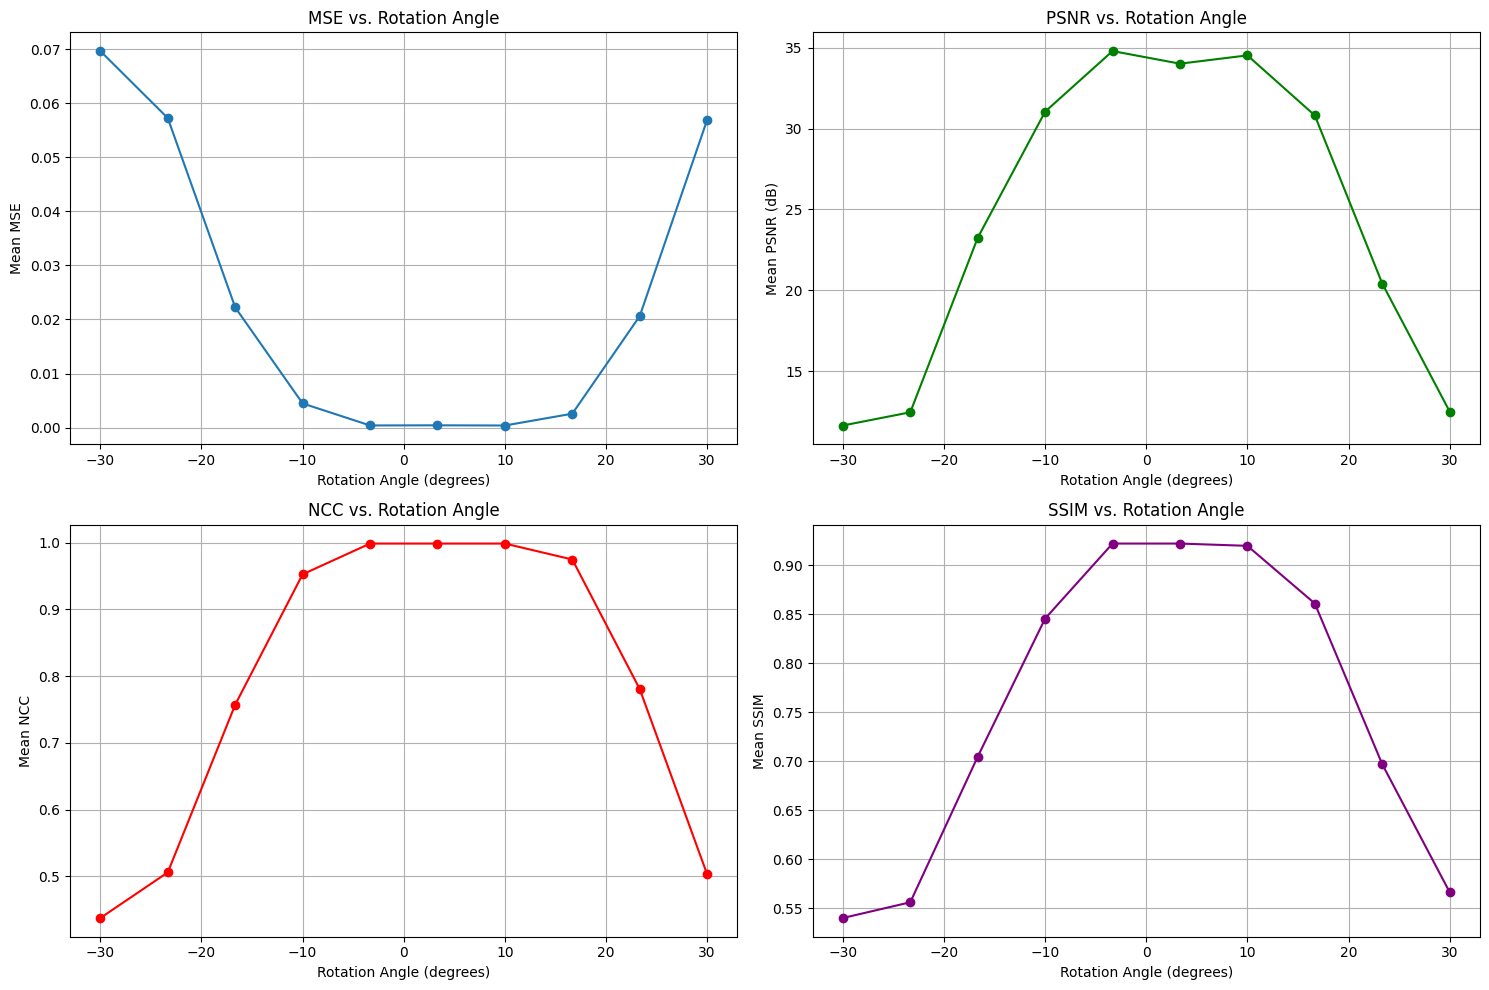

In [11]:

# Calculate the mean metrics for each rotation angle
mean_metrics_by_rotation = df_rotation_metrics.groupby('rotation_angle_deg').mean(numeric_only=True).reset_index()

plt.figure(figsize=(15, 10))

# Plot MSE vs. Rotation Angle
plt.subplot(2, 2, 1)
plt.plot(mean_metrics_by_rotation['rotation_angle_deg'], mean_metrics_by_rotation['MSE'], marker='o')
plt.title('MSE vs. Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Mean MSE')
plt.grid(True)

# Plot PSNR vs. Rotation Angle
plt.subplot(2, 2, 2)
plt.plot(mean_metrics_by_rotation['rotation_angle_deg'], mean_metrics_by_rotation['PSNR'], marker='o', color='green')
plt.title('PSNR vs. Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Mean PSNR (dB)')
plt.grid(True)

# Plot NCC vs. Rotation Angle
plt.subplot(2, 2, 3)
plt.plot(mean_metrics_by_rotation['rotation_angle_deg'], mean_metrics_by_rotation['NCC'], marker='o', color='red')
plt.title('NCC vs. Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Mean NCC')
plt.grid(True)

# Plot SSIM vs. Rotation Angle
plt.subplot(2, 2, 4)
plt.plot(mean_metrics_by_rotation['rotation_angle_deg'], mean_metrics_by_rotation['SSIM'], marker='o', color='purple')
plt.title('SSIM vs. Rotation Angle')
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Mean SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()

# Experiment 3a: Varying Shear$_x$

Goal: analyze impact of varying shear in the x-direction  on image registration metrics.

Shear Factor X values: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3       ]
Theta (radians): 0.17453292519943295
Translation X: 5.0
Translation Y: -10.0
Shear Factor Y: 0.1
Number of X-rays to process for shear experiment: 5


In [ ]:
import time
import random

shear_factor_x_values = np.linspace(0.0, 0.3, 10)

# Reset global variables to default values for this experiment
theta = np.deg2rad(10)               # radians
translation_x = 5.0     # normalized to image scale
translation_y = -10.0
shear_factor_y = 0.1    # Default shear_factor_y value as specified

# Number of random X-rays to process for this experiment
num_xrays_to_process_shear_experiment = 5

print(f"Shear Factor X values: {shear_factor_x_values}")
print(f"Theta (radians): {theta}")
print(f"Translation X: {translation_x}")
print(f"Translation Y: {translation_y}")
print(f"Shear Factor Y: {shear_factor_y}")
print(f"Number of X-rays to process for shear experiment: {num_xrays_to_process_shear_experiment}")

all_shear_metrics = []

# Get all fixed paths first
all_fixed_paths_shear_experiment = sorted(glob.glob(os.path.join(fixed_dir, "*.png")))

# Randomly select a subset of fixed paths if num_xrays_to_process_shear_experiment is set
if num_xrays_to_process_shear_experiment is not None and num_xrays_to_process_shear_experiment < len(all_fixed_paths_shear_experiment):
    fixed_paths_for_shear_experiment = random.sample(all_fixed_paths_shear_experiment, num_xrays_to_process_shear_experiment)
else:
    fixed_paths_for_shear_experiment = all_fixed_paths_shear_experiment

# Total files for this specific experiment iteration
total_files_shear_experiment = len(fixed_paths_for_shear_experiment)

for current_shear_factor_x in shear_factor_x_values:
    # Update the global shear_factor_x variable for the register_pair_and_metrics function
    shear_factor_x = current_shear_factor_x

    print(f"\nProcessing with shear_factor_x: {current_shear_factor_x:.4f}")

    start_time = time.time()  # Start timing for the current shear factor
    current_shear_rows = []
    for i, fixed_path in enumerate(fixed_paths_for_shear_experiment):
        fname = os.path.basename(fixed_path)
        moving_path = None # Assuming synthetic distortion for this experiment

        if os.path.isdir(moving_dir):
            cand = os.path.join(moving_dir, fname)
            if os.path.exists(cand):
                moving_path = cand
            else:
                print(f"[WARN] No moving image for {fname}, skipping.")
                continue

        print(f"  Registering {fname} ({i+1}/{total_files_shear_experiment}) ...")
        _, metrics = register_pair_and_metrics(fixed_path, moving_path, case_id=fname)
        metrics["shear_factor_x"] = current_shear_factor_x
        current_shear_rows.append(metrics)
    end_time = time.time()  # End timing for the current shear factor
    duration = end_time - start_time
    print(f"  Registration for shear_factor_x={current_shear_factor_x:.4f} completed in {duration:.2f} seconds.")

    all_shear_metrics.extend(current_shear_rows)

# Convert all collected metrics to a DataFrame
df_shear_metrics = pd.DataFrame(all_shear_metrics)
df_shear_metrics.head()
print("Done!")


Processing with shear_factor_x: 0.0000
  Registering 00000149_009.png (1/5) ...
  Registering 00000149_007.png (2/5) ...
  Registering 00000150_003.png (3/5) ...
  Registering 00000147_002.png (4/5) ...
  Registering 00000148_000.png (5/5) ...
  Registration for shear_factor_x=0.0000 completed in 63.28 seconds.

Processing with shear_factor_x: 0.0333
  Registering 00000149_009.png (1/5) ...
  Registering 00000149_007.png (2/5) ...
  Registering 00000150_003.png (3/5) ...
  Registering 00000147_002.png (4/5) ...
  Registering 00000148_000.png (5/5) ...
  Registration for shear_factor_x=0.0333 completed in 60.76 seconds.

Processing with shear_factor_x: 0.0667
  Registering 00000149_009.png (1/5) ...
  Registering 00000149_007.png (2/5) ...
  Registering 00000150_003.png (3/5) ...
  Registering 00000147_002.png (4/5) ...
  Registering 00000148_000.png (5/5) ...
  Registration for shear_factor_x=0.0667 completed in 59.57 seconds.

Processing with shear_factor_x: 0.1000
  Registering 0000

,case_id,MSE,PSNR,NCC,SSIM,shear_factor_x
0,00000149_009.png,0.000674,31.714941,0.999259,0.930533,0.0
1,00000149_007.png,0.000155,38.096640,0.999173,0.922166,0.0
2,00000150_003.png,0.000314,35.037352,0.999246,0.929557,0.0
3,00000147_002.png,0.001433,28.437393,0.999267,0.901105,0.0
4,00000148_000.png,0.000172,37.642986,0.998759,0.915462,0.0


In [ ]:
df_shear_metrics

,case_id,MSE,PSNR,NCC,SSIM,shear_factor_x
0,00000149_009.png,0.000674,31.714941,0.999259,0.930533,0.000000
1,00000149_007.png,0.000155,38.096640,0.999173,0.922166,0.000000
2,00000150_003.png,0.000314,35.037352,0.999246,0.929557,0.000000
3,00000147_002.png,0.001433,28.437393,0.999267,0.901105,0.000000
4,00000148_000.png,0.000172,37.642986,0.998759,0.915462,0.000000
5,00000149_009.png,0.000711,31.481283,0.999272,0.931312,0.033333
6,00000149_007.png,0.000400,33.976592,0.999174,0.923860,0.033333
7,00000150_003.png,0.000333,34.778234,0.999240,0.930476,0.033333
8,00000147_002.png,0.001374,28.621407,0.999270,0.898901,0.033333
9,00000148_000.png,0.000118,39.267447,0.998757,0.913861,0.033333


In [ ]:
df_shear_metrics.describe()

,MSE,PSNR,NCC,SSIM,shear_factor_x
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.000600,34.147477,0.998925,0.917933,0.150000
std,0.000608,4.030808,0.001497,0.016905,0.096715
min,0.000107,26.539721,0.988644,0.825702,0.000000
25%,0.000178,31.271536,0.999171,0.914762,0.066667
50%,0.000302,35.205183,0.999239,0.921802,0.150000
75%,0.000746,37.494076,0.999259,0.929715,0.233333
max,0.002218,39.722544,0.999276,0.932801,0.300000


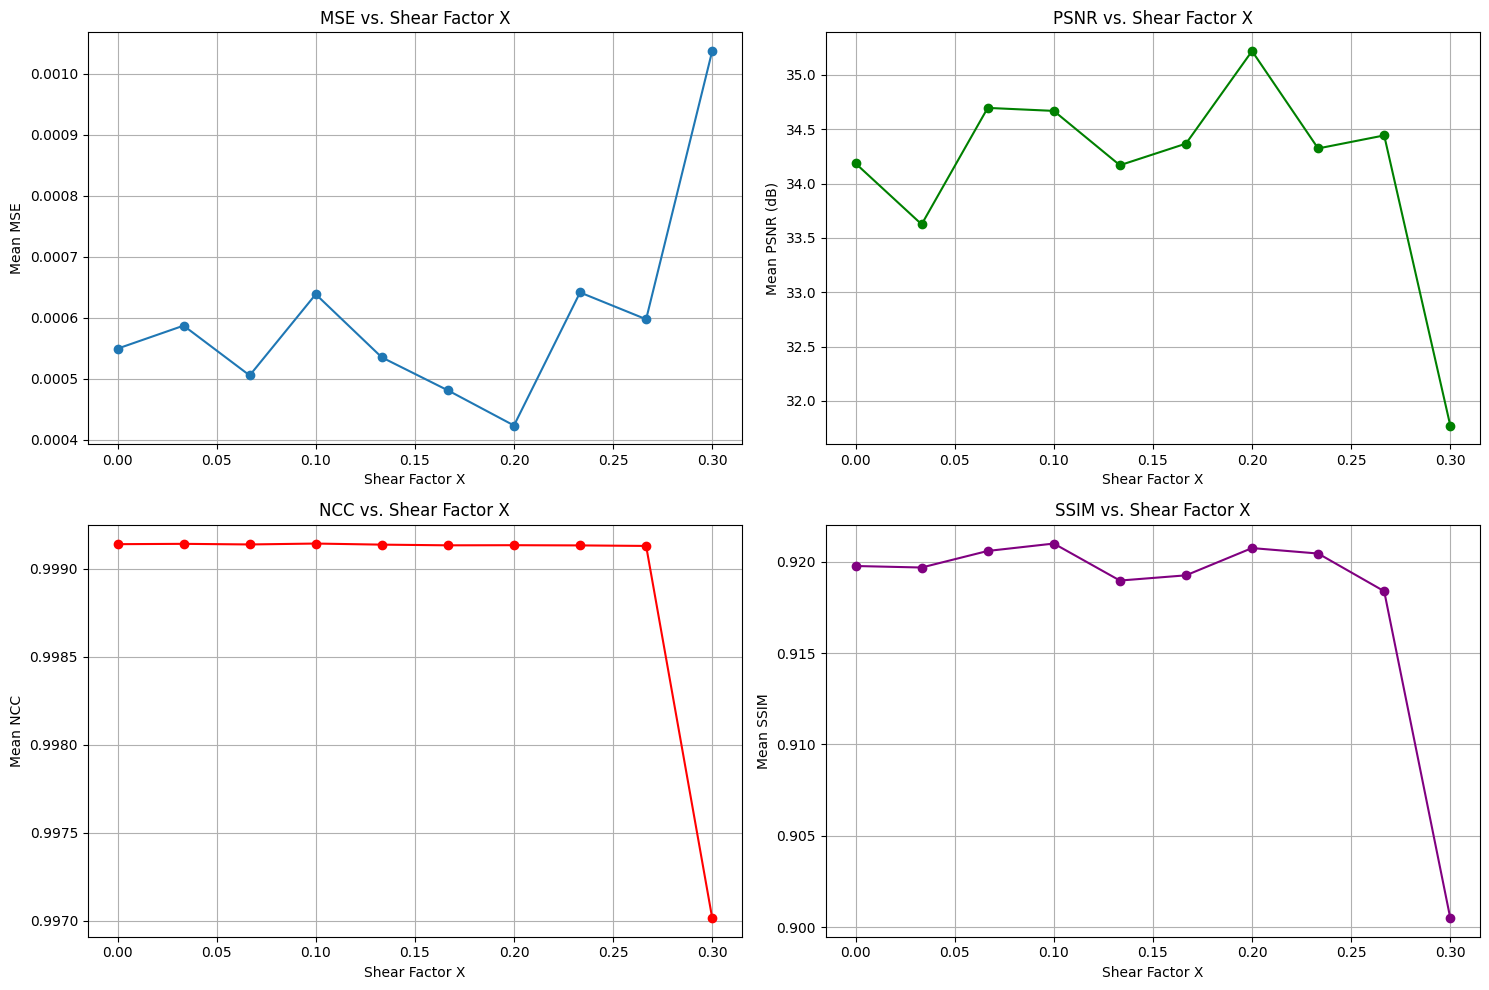

In [ ]:
mean_metrics_by_shear = df_shear_metrics.groupby('shear_factor_x').mean(numeric_only=True).reset_index()
# mean_metrics_by_shear

plt.figure(figsize=(15, 10))

# Plot MSE vs. Shear Factor X
plt.subplot(2, 2, 1)
plt.plot(mean_metrics_by_shear['shear_factor_x'], mean_metrics_by_shear['MSE'], marker='o')
plt.title('MSE vs. Shear Factor X')
plt.xlabel('Shear Factor X')
plt.ylabel('Mean MSE')
# plt.ylim(3e-4,10e-4)
plt.grid(True)

# Plot PSNR vs. Shear Factor X
plt.subplot(2, 2, 2)
plt.plot(mean_metrics_by_shear['shear_factor_x'], mean_metrics_by_shear['PSNR'], marker='o', color='green')
plt.title('PSNR vs. Shear Factor X')
plt.xlabel('Shear Factor X')
plt.ylabel('Mean PSNR (dB)')
# plt.ylim(30.5,34.5)
plt.grid(True)

# Plot NCC vs. Shear Factor X
plt.subplot(2, 2, 3)
plt.plot(mean_metrics_by_shear['shear_factor_x'], mean_metrics_by_shear['NCC'], marker='o', color='red')
plt.title('NCC vs. Shear Factor X')
plt.xlabel('Shear Factor X')
plt.ylabel('Mean NCC')
# plt.ylim(0.9985, 0.999)
plt.grid(True)

# Plot SSIM vs. Shear Factor X
plt.subplot(2, 2, 4)
plt.plot(mean_metrics_by_shear['shear_factor_x'], mean_metrics_by_shear['SSIM'], marker='o', color='purple')
plt.title('SSIM vs. Shear Factor X')
plt.xlabel('Shear Factor X')
plt.ylabel('Mean SSIM')
# plt.ylim(0.9125, 0.925)
plt.grid(True)

plt.tight_layout()
plt.show()

# Experiment 3b: Varying Shear$_y$

Goal: analyze impact of varying shear in the y-direction  on image registration metrics.

In [8]:
import time
import random

shear_factor_y_values = np.linspace(0.0, 0.3, 10)

# Reset global variables to default values for this experiment
theta = np.deg2rad(10)               # radians
translation_x = 5     # normalized to image scale
translation_y = -10.0
shear_factor_x = 0.2    # Default shear_factor_y value as specified

# Number of random X-rays to process for this experiment
num_xrays_to_process_shear_experiment = 5

print(f"Shear Factor Y values: {shear_factor_y_values}")
print(f"Theta (radians): {theta}")
print(f"Translation X: {translation_x}")
print(f"Translation Y: {translation_y}")
print(f"Shear Factor X: {shear_factor_x}")
print(f"Number of X-rays to process for shear experiment: {num_xrays_to_process_shear_experiment}")

all_shear_metrics = []

# Get all fixed paths first
all_fixed_paths_shear_experiment = sorted(glob.glob(os.path.join(fixed_dir, "*.png")))

# Randomly select a subset of fixed paths if num_xrays_to_process_shear_experiment is set
if num_xrays_to_process_shear_experiment is not None and num_xrays_to_process_shear_experiment < len(all_fixed_paths_shear_experiment):
    fixed_paths_for_shear_experiment = random.sample(all_fixed_paths_shear_experiment, num_xrays_to_process_shear_experiment)
else:
    fixed_paths_for_shear_experiment = all_fixed_paths_shear_experiment

# Total files for this specific experiment iteration
total_files_shear_experiment = len(fixed_paths_for_shear_experiment)

for current_shear_factor_y in shear_factor_y_values:
    # Update the global shear_factor_x variable for the register_pair_and_metrics function
    shear_factor_y = current_shear_factor_y

    print(f"\nProcessing with shear_factor_y: {current_shear_factor_y:.4f}")

    start_time = time.time()  # Start timing for the current shear factor
    current_shear_rows = []
    for i, fixed_path in enumerate(fixed_paths_for_shear_experiment):
        fname = os.path.basename(fixed_path)
        moving_path = None # Assuming synthetic distortion for this experiment

        if os.path.isdir(moving_dir):
            cand = os.path.join(moving_dir, fname)
            if os.path.exists(cand):
                moving_path = cand
            else:
                print(f"[WARN] No moving image for {fname}, skipping.")
                continue

        print(f"  Registering {fname} ({i+1}/{total_files_shear_experiment}) ...")
        _, metrics = register_pair_and_metrics(fixed_path, moving_path, case_id=fname)
        metrics["shear_factor_y"] = current_shear_factor_y
        current_shear_rows.append(metrics)
    end_time = time.time()  # End timing for the current shear factor
    duration = end_time - start_time
    print(f"  Registration for shear_factor_y={current_shear_factor_y:.4f} completed in {duration:.2f} seconds.")

    all_shear_metrics.extend(current_shear_rows)

# Convert all collected metrics to a DataFrame
df_shear_y_metrics = pd.DataFrame(all_shear_metrics)
df_shear_y_metrics.head()
print("Done!")

Shear Factor Y values: [0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3       ]
Theta (radians): 0.17453292519943295
Translation X: 5
Translation Y: -10.0
Shear Factor X: 0.2
Number of X-rays to process for shear experiment: 5

Processing with shear_factor_y: 0.0000
  Registering 00000149_009.png (1/5) ...
  Registering 00000149_003.png (2/5) ...
  Registering 00000148_001.png (3/5) ...
  Registering 00000149_002.png (4/5) ...
  Registering 00000150_000.png (5/5) ...
  Registration for shear_factor_y=0.0000 completed in 85.47 seconds.

Processing with shear_factor_y: 0.0333
  Registering 00000149_009.png (1/5) ...
  Registering 00000149_003.png (2/5) ...
  Registering 00000148_001.png (3/5) ...
  Registering 00000149_002.png (4/5) ...
  Registering 00000150_000.png (5/5) ...
  Registration for shear_factor_y=0.0333 completed in 80.57 seconds.

Processing with shear_factor_y: 0.0667
  Registering 00000149_009.png (1/5) ...
  Regist

In [9]:
df_shear_y_metrics

,case_id,MSE,PSNR,NCC,SSIM,shear_factor_y
0,00000149_009.png,0.000562,32.502383,0.999241,0.932008,0.000000
1,00000149_003.png,0.000391,34.080121,0.999290,0.913018,0.000000
2,00000148_001.png,0.000619,32.082360,0.999258,0.927053,0.000000
3,00000149_002.png,0.000483,33.159667,0.999364,0.904015,0.000000
4,00000150_000.png,0.000241,36.178476,0.997731,0.912882,0.000000
5,00000149_009.png,0.000556,32.549685,0.999253,0.931624,0.033333
6,00000149_003.png,0.000399,33.989437,0.999291,0.912828,0.033333
7,00000148_001.png,0.000364,34.389893,0.999255,0.924195,0.033333
8,00000149_002.png,0.001079,29.667931,0.999366,0.912361,0.033333
9,00000150_000.png,0.000231,36.369740,0.997734,0.913608,0.033333


In [10]:
df_shear_y_metrics.describe()

,MSE,PSNR,NCC,SSIM,shear_factor_y
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.007260,28.296524,0.939770,0.832760,0.150000
std,0.012111,7.676688,0.110235,0.129959,0.096715
min,0.000231,14.003109,0.582180,0.584239,0.000000
25%,0.000433,20.461290,0.944991,0.681504,0.066667
50%,0.000570,32.440065,0.999252,0.909485,0.150000
75%,0.009022,33.633656,0.999291,0.914586,0.233333
max,0.039782,36.369740,0.999397,0.932664,0.300000


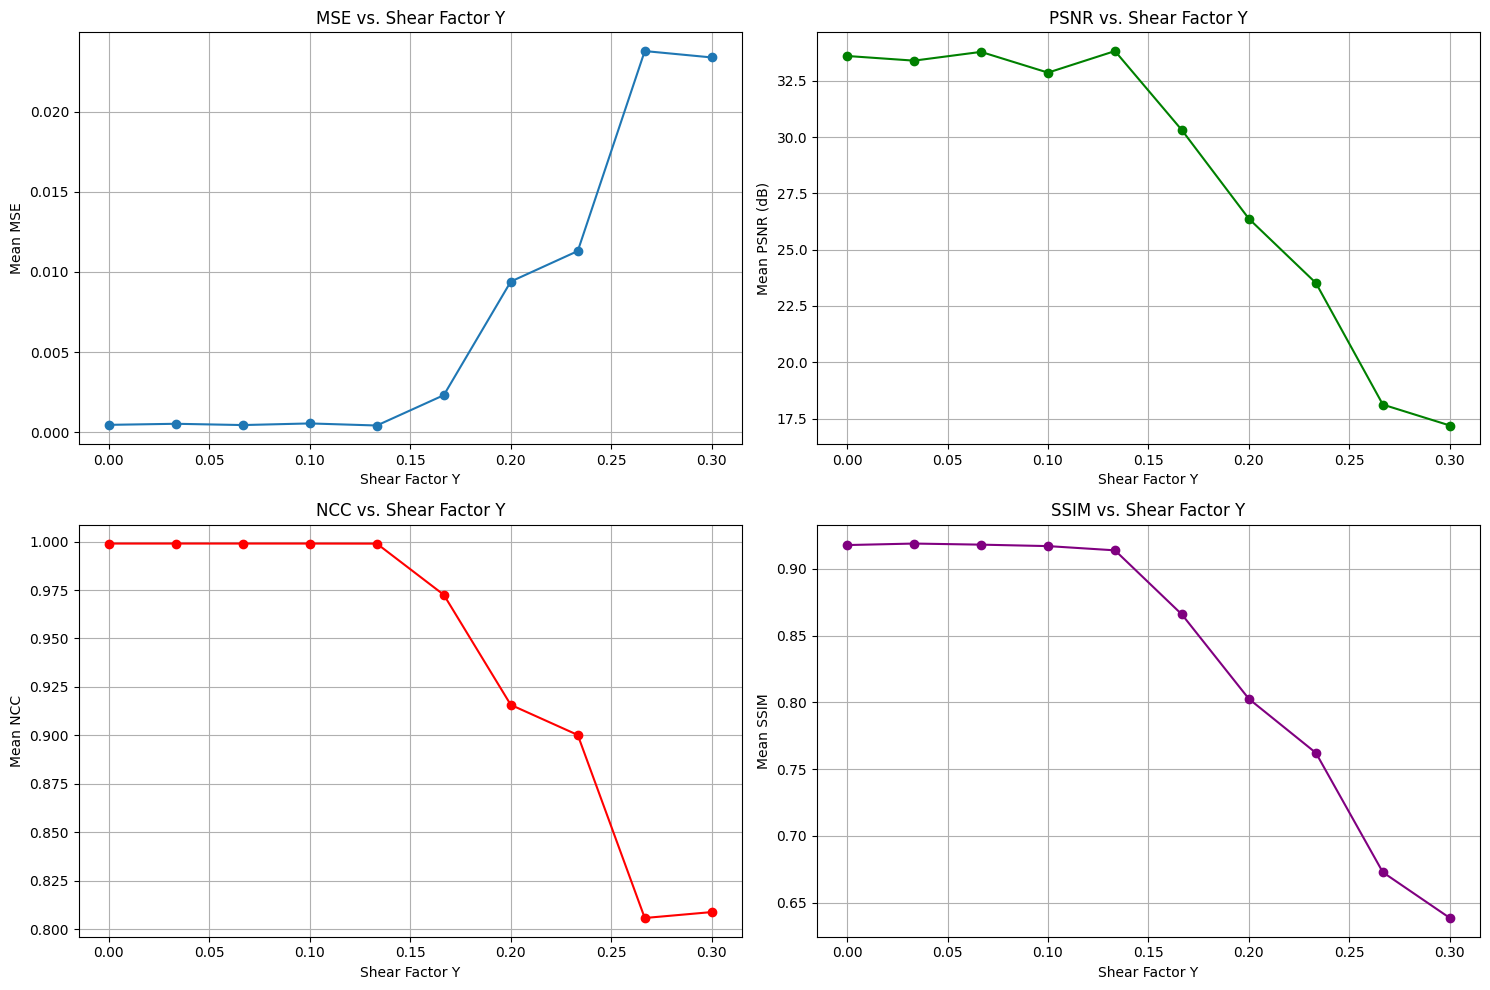

In [11]:
mean_metrics_by_shear = df_shear_y_metrics.groupby('shear_factor_y').mean(numeric_only=True).reset_index()
# mean_metrics_by_shear

plt.figure(figsize=(15, 10))

# Plot MSE vs. Shear Factor Y
plt.subplot(2, 2, 1)
plt.plot(mean_metrics_by_shear['shear_factor_y'], mean_metrics_by_shear['MSE'], marker='o')
plt.title('MSE vs. Shear Factor Y')
plt.xlabel('Shear Factor Y')
plt.ylabel('Mean MSE')
# plt.ylim(3e-4,10e-4)
plt.grid(True)

# Plot PSNR vs. Shear Factor Y
plt.subplot(2, 2, 2)
plt.plot(mean_metrics_by_shear['shear_factor_y'], mean_metrics_by_shear['PSNR'], marker='o', color='green')
plt.title('PSNR vs. Shear Factor Y')
plt.xlabel('Shear Factor Y')
plt.ylabel('Mean PSNR (dB)')
# plt.ylim(30.5,34.5)
plt.grid(True)

# Plot NCC vs. Shear Factor Y
plt.subplot(2, 2, 3)
plt.plot(mean_metrics_by_shear['shear_factor_y'], mean_metrics_by_shear['NCC'], marker='o', color='red')
plt.title('NCC vs. Shear Factor Y')
plt.xlabel('Shear Factor Y')
plt.ylabel('Mean NCC')
# plt.ylim(0.9985, 0.999)
plt.grid(True)

# Plot SSIM vs. Shear Factor Y
plt.subplot(2, 2, 4)
plt.plot(mean_metrics_by_shear['shear_factor_y'], mean_metrics_by_shear['SSIM'], marker='o', color='purple')
plt.title('SSIM vs. Shear Factor Y')
plt.xlabel('Shear Factor Y')
plt.ylabel('Mean SSIM')
# plt.ylim(0.9125, 0.925)
plt.grid(True)

plt.tight_layout()
plt.show()